# <font color='BLUE'> DAB401 - FINAL PROJECT - STOCK PRICE PREDICTION  </font>

### <font color='BLUE'>GROUP NUMBER: 14   </font>

   - Trang Bui- W0753523  
   - Sowjanya Chilluveru: 0755566  
   - Sriram bonasu: 0756345  



### <font color='BLUE'>   Dataset Description </font>
- Attributes:  
o Date - the date  
o Open – the stock's opening price  
o High – for That day's high price  
o Low – for That day's low price  
o Close – for the closing price of the day  
o Volume – as of the sum of stocks exchanged in the day (the number of shares passed from one onwner to another in the day).  
o Adj Close – indicates the closing price of the stock that has been changed to include any distributions / corporate actions that occur before opening the next day.  

## <font color='BLUE'>  Contribution  </font>
- Trang Bui: Looking for Dataset + Data Pre-processing & Exploration, LSTM models + coding combination and do final conclusion
- Sowjanja: ML models
- Sriram: ML models  

In [1]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import time
import os, sys    
from datetime import datetime, date
from pandas_datareader.data import DataReader

from statsmodels.tools.eval_measures import rmse
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import math
from math import sqrt

pd.set_option('display.float_format', lambda x: '%.2f' % x)

## <font color='BLUE'> Load data and Data pre-processing </font>

In [2]:
def load_data(p_stockName, p_year):               
    enddate = datetime.now()
    startdate = datetime(enddate.year - p_year, enddate.month, enddate.day)
    data_raw=DataReader(p_stockName, 'yahoo', startdate, enddate)
    return data_raw

p_stockname= 'DOW' #'TSLA' #GOOGL
p_year=3
data_raw = load_data(p_stockname,p_year)
print("data_raw.shape:",data_raw.shape)
print("data_raw.info:", data_raw.info())

data_raw.shape: (523, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523 entries, 2019-03-20 to 2021-04-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       523 non-null    float64
 1   Low        523 non-null    float64
 2   Open       523 non-null    float64
 3   Close      523 non-null    float64
 4   Volume     523 non-null    float64
 5   Adj Close  523 non-null    float64
dtypes: float64(6)
memory usage: 28.6 KB
data_raw.info: None


In [3]:
data_raw.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-03-20,53.50,49.50,52.75,49.80,2350800.00,44.31
2019-03-21,50.00,48.20,49.99,48.98,1764700.00,43.58
2019-03-22,49.95,48.16,48.80,48.60,844700.00,43.25
2019-03-25,49.40,48.00,48.60,49.15,440900.00,43.73
2019-03-26,49.75,48.18,49.00,48.85,504700.00,43.47


In [4]:
df = pd.DataFrame()
df = data_raw[['Close']]
print('df.shape',df.shape)
df.head(3)

df.shape (523, 1)


,Close
Date,
2019-03-20,49.80
2019-03-21,48.98
2019-03-22,48.60


In [5]:
def sniff_modified(df):
    with pd.option_context("display.max_colwidth", 100):
        info = pd.DataFrame()
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        info['nb of unique'] = df.apply(lambda x: len(x.unique()))
        info['unique values'] =  df.T.apply(lambda x: x.unique(), axis=1)
        return info.sort_values('data type')
    
def check_missing_data(df):
    df_info = sniff_modified(df)
    pd.set_option('display.max_rows', None)
    nb_missing_cols = len(df_info[df_info['percent missing']>0])
    if (nb_missing_cols ==0):
        print('There is no missing data cols in the dataset')
    return df_info, nb_missing_cols

data_missing_info, nb_missing_cols = check_missing_data(df)

if (nb_missing_cols>0):
    print("Missing Data.info:")
    print(data_missing_info.info())


df.to_csv('stock_price_after_preprocessing.csv', index = True)
    
print("Data.info [After Preprocessing]:")
print(df.info())

df.head()

There is no missing data cols in the dataset
Data.info [After Preprocessing]:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523 entries, 2019-03-20 to 2021-04-15
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   523 non-null    float64
dtypes: float64(1)
memory usage: 8.2 KB
None


,Close
Date,
2019-03-20,49.80
2019-03-21,48.98
2019-03-22,48.60
2019-03-25,49.15
2019-03-26,48.85


## <font color='BLUE'>  Data Exploration </font>

In [6]:
df = pd.read_csv('stock_price_after_preprocessing.csv', index_col ='Date', parse_dates =True)

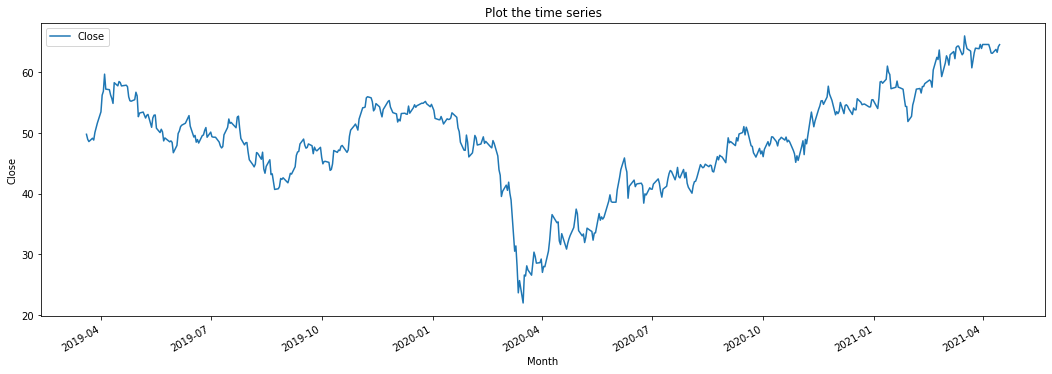

In [7]:
def fn_plottimeseries(df):
    df.plot(figsize=(18, 6))
    plt.title('Plot the time series')
    plt.xlabel('Month')
    plt.ylabel('Close')
    plt.legend()
    plt.show()

fn_plottimeseries(df)

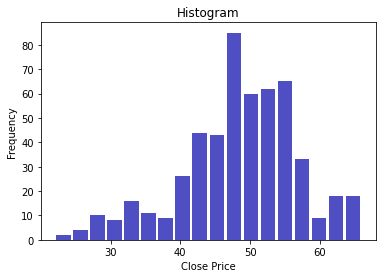

In [8]:
def display_histogram(X):
    plt.hist(x=X, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
    plt.xlabel('Close Price')
    plt.ylabel('Frequency')
    plt.title('Histogram')

display_histogram(df["Close"])

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,523.00,48.64,8.33,22.00,44.05,49.01,54.23,66.01


In [10]:
print('number of prices <= 44: ', len(df[df.Close<=44]))
print('number of prices > 54: ', len(df[df.Close>54]))

(len(df[df.Close<=44])+len(df[df.Close>54]))/len(df)

number of prices <= 44:  130
number of prices > 54:  137


0.5105162523900574

#### <font color='BLUE'>  Comments </font>
- The chart demonstrated the fluctuation of daily price of SOW stock in a perriod of 3 most recent years. It can be seen that the price fluctuated in the range from 40 to 60. The price rapid went down to bottom at 22 on April 2020. After that, the price fluctuated with up direction. The price is getting peak on April 2021 (now).
  
- Detail of data distribution is shown in the histogram:  
    - Count: data rows that correspond to 3-year period
    - Mean: the average of stock price
    - STD (standard deviation) is not too much far from the mean value.  
    - Min: the min price    
    - Max: the max price   
    - 25%. 50%, 75% percentiles shows that around 50% data rows distributes densely in the range of 25th and 75th percentile. The number out of the percentile range is around one-half. Hence, the shape look left-skewed.  

## <font color='BLUE'>  Decompose the time series </font>

DECOMPOSE THE TIME SERIES


<Figure size 432x288 with 0 Axes>

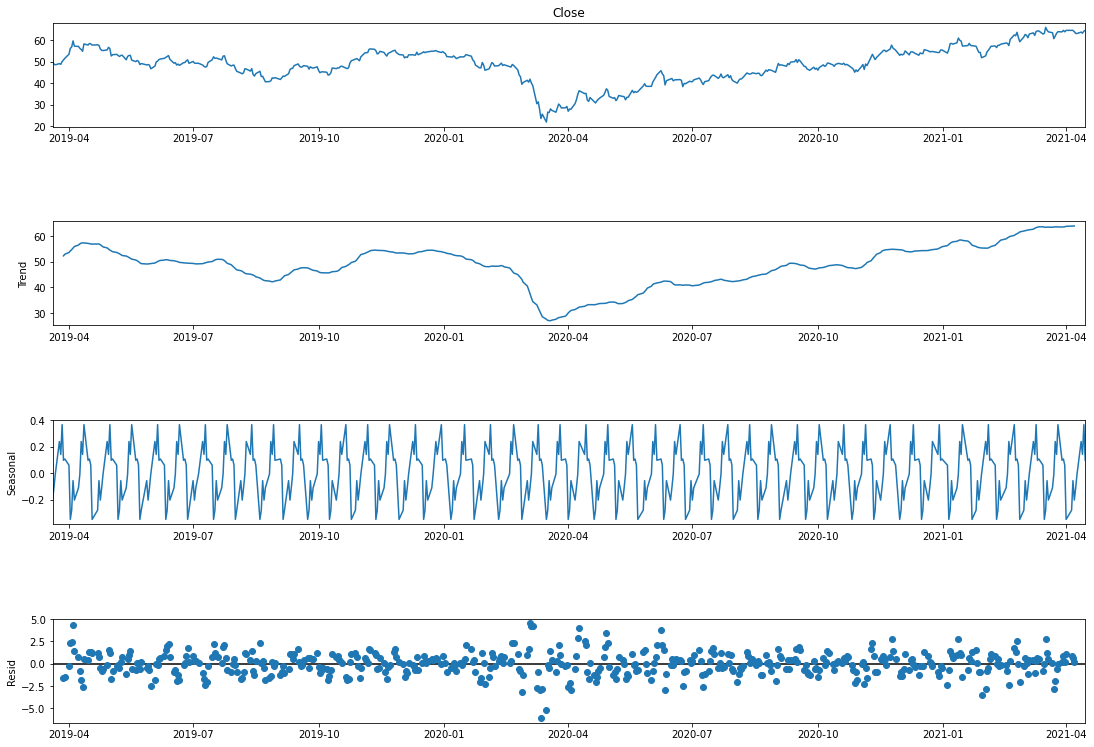

In [11]:
print('DECOMPOSE THE TIME SERIES')
# Import seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform additive decomposition
# Decompose the time series
decomp = seasonal_decompose(df['Close'], freq=12)

# Plot decomposition
fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(18, 12)

#### <font color='BLUE'>  Comments </font>
- The first line graph expresses the stock prices that fluctuated in the range from 40 to 60 in the period from now backward 3 recent years. The stock prices abnormally went down to bottom on April 2020.  
- The stock prices are quite stable, no trend can be seen clearly. 
- The seasonal graph indicated that the stock price fluctuated repeatly.  
- Residual error is between [-5, 5].  


# <font color='RED'> LSTM Model </font>

### Common functions

In [12]:
def display_history(history):
    history.history.keys()
    history_dict = history.history # the dictionary that has the information on loss and accuracy per epoch
    
    loss_values = history_dict['loss']   # training loss
    val_loss_values = history_dict['val_loss'] # validation loss

    plt.plot(history.history['loss'], 'b', label="Training Loss")
    plt.plot(history.history['val_loss'], 'r', label="Test Loss")
    plt.title("Training and Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    return

    
def plot_prediction(df, train_predict, test_predict, time_step):
    # shifting train    
    train_plot = np.empty_like(df) # create an array with the same shape as provided
    train_plot[:, :] = np.nan
    train_plot[time_step: len(train_predict)+time_step, :] = train_predict
    # shifting test predictions for plotting
    test_plot = np.empty_like(df)
    test_plot[:, :] = np.nan
    test_plot[len(train_predict)+(time_step*2)+1:len(df)-1, :] = test_predict
    # plot baseline and predictions
    plt.plot(scalar.inverse_transform(df))
    plt.plot(train_plot)
    plt.plot(test_plot)
    plt.show()
    
# Make predictions
def do_prediction(model, train_X, test_X, train_Y, test_Y, df, scalar, time_step):
    train_Y_predict = model.predict(train_X)
    test_Y_predict = model.predict(test_X)
    
    # inverting predictions
    train_Y_predict = scalar.inverse_transform(train_Y_predict)
    train_Y = scalar.inverse_transform([train_Y])
    test_Y_predict = scalar.inverse_transform(test_Y_predict)
    test_Y = scalar.inverse_transform([test_Y])
    
    # calculate root mean squared error
    train_score = math.sqrt(mean_squared_error(train_Y[0], train_Y_predict[:,0]))    
    test_score = math.sqrt(mean_squared_error(test_Y[0], test_Y_predict[:,0]))
      
    MAE_train=np.mean(abs(train_Y- train_Y_predict))/np.mean(train_Y)     
    MAE_test=np.mean(abs(test_Y-test_Y_predict))/np.mean(test_Y)
   

    print('Train: %.2f RMSE' % (train_score))
    print('Test: %.2f RMSE' % (test_score))
    print('Train: %.2f MAE' % (MAE_train))
    print('Test: %.2f MAE' % (MAE_test))
    
    result={'train RMSE score':train_score,'test RMSE score':test_score, 'MAE train':MAE_train,'MAE test':MAE_test}
   
    plot_prediction(df, train_Y_predict, test_Y_predict, time_step)
        
    return result



In [13]:
df = pd.read_csv('stock_price_after_preprocessing.csv')
print('df.shape:', df.shape)
df.head(10)

df.shape: (523, 2)


,Date,Close
0,2019-03-20,49.80
1,2019-03-21,48.98
2,2019-03-22,48.60
3,2019-03-25,49.15
4,2019-03-26,48.85
5,2019-03-27,50.10
6,2019-03-28,50.85
7,2019-03-29,51.63
8,2019-04-01,53.50
9,2019-04-02,56.25


In [14]:
df_lstm = df.iloc[:,1].values
df_lstm[:10]

array([49.79999924, 48.97999954, 48.59999847, 49.15000153, 48.84999847,
       50.09999847, 50.84999847, 51.63000107, 53.5       , 56.25      ])

In [15]:
df_lstm = df_lstm.reshape(-1,1)   #reshape before scaling
df_lstm = df_lstm.astype('float32')  # convert array to float32
print('df_lstm.dtype',df_lstm.dtype)
print('df_lstm.shape',df_lstm.shape)
# df_lstm[:10]

df_lstm.dtype float32
df_lstm.shape (523, 1)


In [16]:
# Scaling the data
scalar =MinMaxScaler(feature_range=(0,1))
df_lstm =scalar.fit_transform(df_lstm)
print('df_lstm.shape after fit_Transform:',df_lstm.shape)

df_lstm.shape after fit_Transform: (523, 1)


In [17]:
# Split into train and test
train = df_lstm[:-150,:]
test = df_lstm[-150:,:]
print('len(train):',len(train))
print('len(test):',len(test))
print('type_train',type(train))
# train

len(train): 373
len(test): 150
type_train <class 'numpy.ndarray'>


In [18]:
# Building the 2D array for supervised learning
def create_data(sequence, time_step, nb_predict):
    dataX = []
    dataY = []
    nloop = len(sequence)-time_step-nb_predict
    for i in range(nloop):
        a = sequence[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(sequence[i + time_step, 0])
    return np.array(dataX),  np.array(dataY)

In [19]:
time_step = 1  # input [time_step] values to predict [nb_predict] value
nb_predict = 1

# Apply the 2D array function to train and test datasets
train_X, train_Y = create_data(train,time_step, nb_predict)
test_X, test_Y = create_data(test, time_step, nb_predict)
print('len train_X',len(train_X))
print('len train_Y',len(train_Y))
print('len test_X',len(test_X))
print('len test_Y',len(test_Y))
print('train_X.shape',train_X.shape)
print('train_Y.shape',train_Y.shape)
print('test_X.shape',test_X.shape)
print('test_Y.shape',test_Y.shape)

len train_X 371
len train_Y 371
len test_X 148
len test_Y 148
train_X.shape (371, 1)
train_Y.shape (371,)
test_X.shape (148, 1)
test_Y.shape (148,)


In [20]:
# train_X

In [21]:
# train_Y

In [22]:
# train_Y_temp = train_Y.reshape(-1,1)
# df_temp=np.concatenate((train_X,train_Y_temp),axis=1)
# df_temp

In [23]:
# transform input from [samples, features] to [samples, timesteps, features] basically from 2D to 3D
nb_samples = train_X.shape[0]
nb_features = train_X.shape[1]
train_X = np.reshape(train_X, (nb_samples, time_step, nb_features))
print('train_X_reshape:',train_X.shape)
nb_samples = test_X.shape[0]
nb_features = test_X.shape[1]
test_X = np.reshape(test_X, (nb_samples, time_step, nb_features))
print('test_X_reshape:',test_X.shape)

train_X_reshape: (371, 1, 1)
test_X_reshape: (148, 1, 1)


### Build the simple LSTM model

BUILD LSTM MODEL============================================================================================
----------Optimizer: adam
----------Activation:  relu
----------Input shape:  (1, 1)
----------Loss:  mse
----------Number of p_epochs: 50
----------Batch Size 10


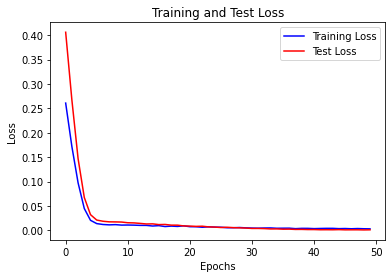

Train: 1.56 RMSE
Test: 1.48 RMSE
Train: 0.18 MAE
Test: 0.12 MAE


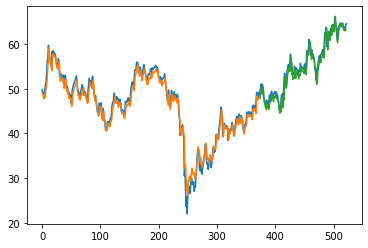

BUILD LSTM MODEL============================================================================================
----------Optimizer: adam
----------Activation:  tanh
----------Input shape:  (1, 1)
----------Loss:  mse
----------Number of p_epochs: 50
----------Batch Size 30


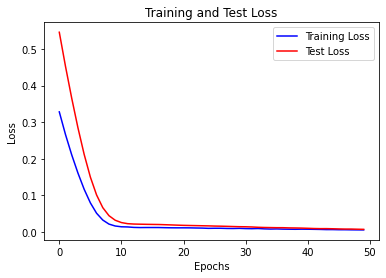

Train: 2.99 RMSE
Test: 3.71 RMSE
Train: 0.15 MAE
Test: 0.11 MAE


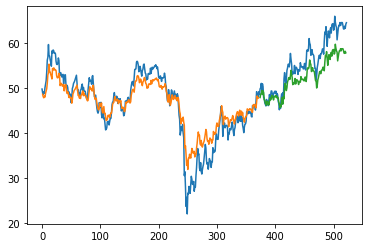

BUILD LSTM MODEL============================================================================================
----------Optimizer: adam
----------Activation:  sigmoid
----------Input shape:  (1, 1)
----------Loss:  mse
----------Number of p_epochs: 50
----------Batch Size 10


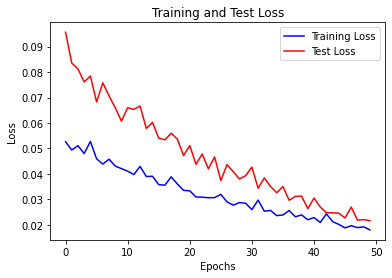

Train: 3.75 RMSE
Test: 6.47 RMSE
Train: 0.16 MAE
Test: 0.13 MAE


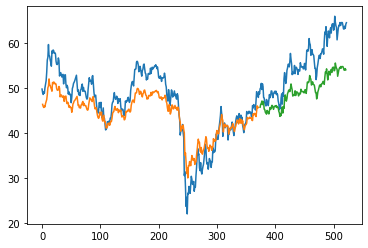

BUILD LSTM MODEL============================================================================================
----------Optimizer: rmsprop
----------Activation:  relu
----------Input shape:  (1, 1)
----------Loss:  mse
----------Number of p_epochs: 50
----------Batch Size 3


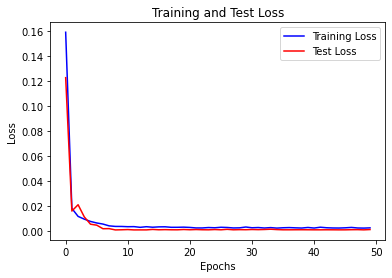

Train: 1.72 RMSE
Test: 1.56 RMSE
Train: 0.18 MAE
Test: 0.13 MAE


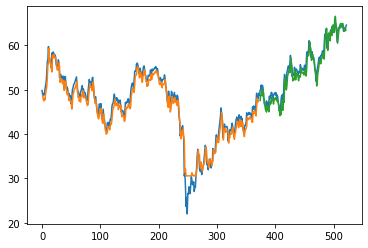

BUILD LSTM MODEL============================================================================================
----------Optimizer: rmsprop
----------Activation:  sigmoid
----------Input shape:  (1, 1)
----------Loss:  mse
----------Number of p_epochs: 50
----------Batch Size 3


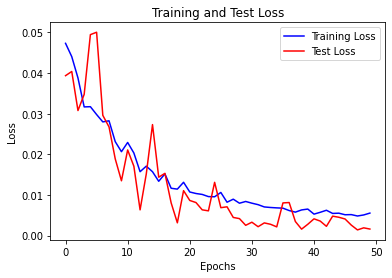

Train: 1.97 RMSE
Test: 1.76 RMSE
Train: 0.17 MAE
Test: 0.11 MAE


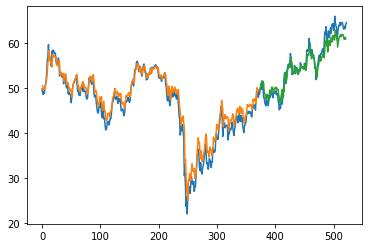

BUILD LSTM MODEL============================================================================================
----------Optimizer: sgd
----------Activation:  relu
----------Input shape:  (1, 1)
----------Loss:  mse
----------Number of p_epochs: 50
----------Batch Size 3


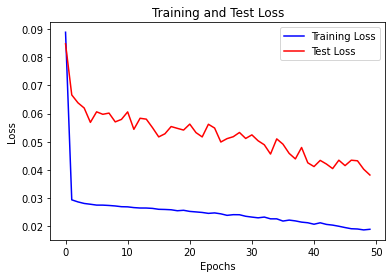

Train: 5.90 RMSE
Test: 8.60 RMSE
Train: 0.13 MAE
Test: 0.14 MAE


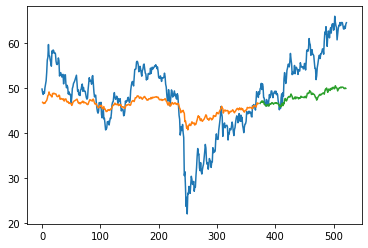

In [24]:
from collections import OrderedDict


def fit_lstm(p_optimizer, p_activation, p_input_shape, p_loss, train_X, train_Y, test_X, test_Y, p_batch_size, p_epochs, p_verbose, p_shuffle):
    print('BUILD LSTM MODEL============================================================================================')
    print('----------Optimizer:', p_optimizer)
    print('----------Activation: ',p_activation)
    print('----------Input shape: ', p_input_shape)
    print('----------Loss: ',p_loss) 
    print('----------Number of p_epochs:',p_epochs)
    print('----------Batch Size',p_batch_size)
    start_time = time.time() 
    
    model = Sequential()
    # Adding the input layer and LSTM layer
    model.add(LSTM(units=50, activation= p_activation, input_shape =p_input_shape))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(optimizer =p_optimizer, loss=p_loss,metrics=['acc'])
        
    history = model.fit(train_X, train_Y, batch_size=p_batch_size, epochs =p_epochs, validation_data=(test_X, test_Y), verbose=p_verbose,shuffle=p_shuffle)
    training_duration = time.time() - start_time
    display_history(history)
    
    result = do_prediction(model, train_X, test_X, train_Y, test_Y, df_lstm, scalar, time_step)
    
    info={'Optimizer':p_optimizer, 'Activation':p_activation,'Loss':p_loss,'Nb Epochs':p_epochs,'Input shape':p_input_shape,'Batch size':p_batch_size,'Training Duration':training_duration}
    result_info = dict(info)    
    result_info.update(result)
    
    return result_info, model



df_score = pd.DataFrame()

p_optimizer='adam'
p_input_shape = (train_X.shape[1], train_X.shape[2]) #(1, time_sttime_stepep_back)
p_loss = 'mse'
p_activation='relu'
p_batch_size = 10
p_epochs=50
p_verbose=0
p_shuffle=False
result_info,model = fit_lstm(p_optimizer, p_activation, p_input_shape, p_loss, train_X, train_Y, test_X, test_Y, p_batch_size, p_epochs, p_verbose, p_shuffle)
df_score=df_score.append(OrderedDict(result_info),ignore_index=True)

p_optimizer='adam'
p_input_shape = (train_X.shape[1], train_X.shape[2]) #(1, time_sttime_stepep_back)
p_loss = 'mse'
p_activation='tanh'
p_batch_size =30
p_epochs=50
p_verbose=0
p_shuffle=False
result_info,model = fit_lstm(p_optimizer, p_activation, p_input_shape, p_loss, train_X, train_Y, test_X, test_Y, p_batch_size, p_epochs, p_verbose, p_shuffle)
df_score=df_score.append(OrderedDict(result_info),ignore_index=True)

p_optimizer='adam'
p_input_shape = (train_X.shape[1], train_X.shape[2]) #(1, time_sttime_stepep_back)
p_loss = 'mse'
p_activation='sigmoid'
p_batch_size =10
p_epochs=50
p_verbose=0
p_shuffle=False
result_info,model = fit_lstm(p_optimizer, p_activation, p_input_shape, p_loss, train_X, train_Y, test_X, test_Y, p_batch_size, p_epochs, p_verbose, p_shuffle)
df_score=df_score.append(OrderedDict(result_info),ignore_index=True)

p_optimizer='rmsprop'
p_input_shape = (train_X.shape[1], train_X.shape[2]) #(1, time_sttime_stepep_back)
p_loss = 'mse'
p_activation='relu'
p_batch_size = 3
p_epochs=50
p_verbose=0
p_shuffle=True
result_info,model = fit_lstm(p_optimizer, p_activation, p_input_shape, p_loss, train_X, train_Y, test_X, test_Y, p_batch_size, p_epochs, p_verbose, p_shuffle)
df_score=df_score.append(OrderedDict(result_info),ignore_index=True)

p_optimizer='rmsprop'
p_input_shape = (train_X.shape[1], train_X.shape[2]) #(1, time_sttime_stepep_back)
p_loss = 'mse'
p_activation='sigmoid'
p_batch_size = 3
p_epochs=50
p_verbose=0
p_shuffle=True
result_info,model = fit_lstm(p_optimizer, p_activation, p_input_shape, p_loss, train_X, train_Y, test_X, test_Y, p_batch_size, p_epochs, p_verbose, p_shuffle)
df_score=df_score.append(OrderedDict(result_info),ignore_index=True)

p_optimizer='sgd'
p_input_shape = (train_X.shape[1], train_X.shape[2]) #(1, time_sttime_stepep_back)
p_loss = 'mse'
p_activation='relu'
p_batch_size = 3
p_epochs=50
p_verbose=0
p_shuffle=True
result_info,model = fit_lstm(p_optimizer, p_activation, p_input_shape, p_loss, train_X, train_Y, test_X, test_Y, p_batch_size, p_epochs, p_verbose, p_shuffle)
df_score=df_score.append(OrderedDict(result_info),ignore_index=True)


In [25]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_score.sort_values(by=['train RMSE score','test RMSE score','MAE test','MAE train'], inplace=True, ascending=True)
df_score

,Activation,Batch size,Input shape,Loss,MAE test,MAE train,Nb Epochs,Optimizer,Training Duration,test RMSE score,train RMSE score
0,relu,10.00,"(1, 1)",mse,0.12,0.18,50.00,adam,6.11,1.48,1.56
3,relu,3.00,"(1, 1)",mse,0.13,0.18,50.00,rmsprop,9.80,1.56,1.72
4,sigmoid,3.00,"(1, 1)",mse,0.11,0.17,50.00,rmsprop,9.34,1.76,1.97
1,tanh,30.00,"(1, 1)",mse,0.11,0.15,50.00,adam,6.28,3.71,2.99
2,sigmoid,10.00,"(1, 1)",mse,0.13,0.16,50.00,adam,5.21,6.47,3.75
5,relu,3.00,"(1, 1)",mse,0.14,0.13,50.00,sgd,8.58,8.60,5.90


## <font color='GREEN'>  Use the best LSTM model to forecast next 12-months period </font>

The best LSTM model in this work with below parameters: 
BUILD LSTM MODEL============================================================================================
----------Optimizer: adam
----------Activation:  relu
----------Input shape:  (1, 1)
----------Loss:  mse
----------Number of p_epochs: 50
----------Batch Size 10


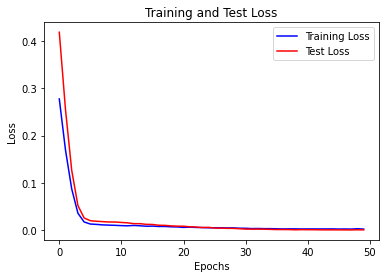

Train: 1.51 RMSE
Test: 1.45 RMSE
Train: 0.18 MAE
Test: 0.12 MAE


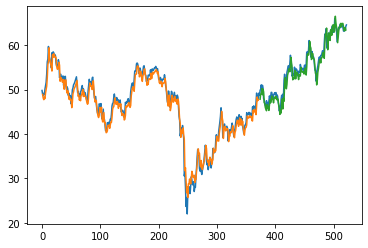

FORECAST NEXT 2 WEEKS (14 DAYS) PERIOD USING THE BEST LSTM MODEL
x=[[1.0365809]]


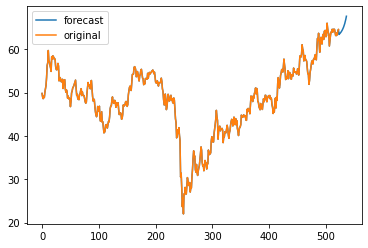

In [26]:
def forecast(model, train_X, test_X, train_Y, test_Y, n_period, time_step):
    x = test_X[-1]
    preds = []
    for i in range(n_period):
        data = np.expand_dims(x, axis=0)
        prediction = model.predict(data)
        preds.append([prediction[0][0]])
        x = np.delete(x, 0, axis=0) # delete first row
        x = np.vstack([x, prediction]) # add prediction
    print(f"x={x}")
    return preds

def plot_forecast(df,df_forecast12):
    df_forecast12=scalar.inverse_transform(df_forecast12)
    df=scalar.inverse_transform(df)
    plt.plot(df_forecast12,label='forecast')
    plt.plot(df,label='original')
    plt.legend()
    plt.show()

print('============================================================================================================')
print('The best LSTM model in this work with below parameters: ')
p_optimizer= df_score.iloc[0]['Optimizer'] 
p_input_shape = df_score.iloc[0]['Input shape'] 
p_loss = df_score.iloc[0]['Loss'] 
p_activation= df_score.iloc[0]['Activation'] 
p_batch_size = int(df_score.iloc[0]['Batch size']) 
p_epochs= int(df_score.iloc[0]['Nb Epochs']) 
p_verbose=0
p_shuffle= False
result_info,model = fit_lstm(p_optimizer, p_activation, p_input_shape, p_loss, train_X, train_Y, test_X, test_Y, p_batch_size, p_epochs, p_verbose, p_shuffle)
df_score=df_score.append(OrderedDict(result_info),ignore_index=True)

final_result = {'Model': 'LSTM', 'MAE Train': result_info['MAE train'], 'MAE Test':result_info['MAE test']}
df_final_result=pd.DataFrame()
df_final_result=df_final_result.append(OrderedDict(final_result),ignore_index=True)


print('FORECAST NEXT 2 WEEKS (14 DAYS) PERIOD USING THE BEST LSTM MODEL')
n_period = 14
time_step=1
df_preds = forecast(model,train_X, test_X, train_Y, test_Y, n_period, time_step)      
df_forecast=np.append(df_lstm,df_preds).reshape(-1,1)
plot_forecast(df_lstm,df_forecast)

# <font color='RED'> Moving Average </font>

In [27]:
df = pd.read_csv('stock_price_after_preprocessing.csv', index_col ='Date', parse_dates =True)
print(df.shape)
df.head()

(523, 1)


,Close
Date,
2019-03-20,49.80
2019-03-21,48.98
2019-03-22,48.60
2019-03-25,49.15
2019-03-26,48.85


In [28]:
train=df[0:-60] 
test=df[-60:]
print(train.shape)
print(test.shape)

(463, 1)
(60, 1)


In [29]:
df['MA_12'] = df.Close.rolling(12,min_periods=1).mean()

In [30]:
df.head()

,Close,MA_12
Date,,
2019-03-20,49.80,49.80
2019-03-21,48.98,49.39
2019-03-22,48.60,49.13
2019-03-25,49.15,49.13
2019-03-26,48.85,49.08


In [31]:
mae = metrics.mean_absolute_error(df['Close'], df['MA_12'])
mse = metrics.mean_squared_error(df['Close'], df['MA_12'])
rmse = np.sqrt(mse)  

final_result = {'Model': 'MA', 'MAE Train': mae, 'MAE Test':mae}
df_final_result=df_final_result.append(OrderedDict(final_result),ignore_index=True)

print('MAE = ',round(mae,2))
print('MSE = ',round(mse,2))
print('RMSE = ',round(rmse,2))

MAE =  1.74
MSE =  5.66
RMSE =  2.38


In [32]:
df.head()

,Close,MA_12
Date,,
2019-03-20,49.80,49.80
2019-03-21,48.98,49.39
2019-03-22,48.60,49.13
2019-03-25,49.15,49.13
2019-03-26,48.85,49.08


Text(0, 0.5, 'Close')

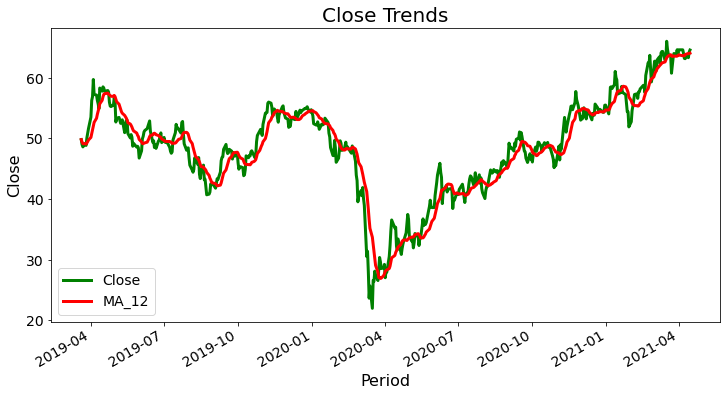

In [33]:
# colors for the line plot
colors = ['green', 'red','blue']

# line plot for Close Price
df.plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Close','MA_12' ], fontsize=14)

# title and labels
plt.title('Close Trends', fontsize=20)
plt.xlabel('Period', fontsize=16)
plt.ylabel('Close', fontsize=16)

# <font color='RED'> Exponential Smoothing (SES, DES, TES ) </font>

In [34]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from math import sqrt

df = pd.read_csv('stock_price_after_preprocessing.csv', index_col ='Date', parse_dates =True)
print(df.shape)
df.head()

(523, 1)


,Close
Date,
2019-03-20,49.80
2019-03-21,48.98
2019-03-22,48.60
2019-03-25,49.15
2019-03-26,48.85


In [35]:
train=df[0:-60] 
test=df[-60:]
print(train.shape)
print(test.shape)

(463, 1)
(60, 1)


## Simple Exponential Smoothing

MAE 3.92
MSE 20.02
RMSE 4.47


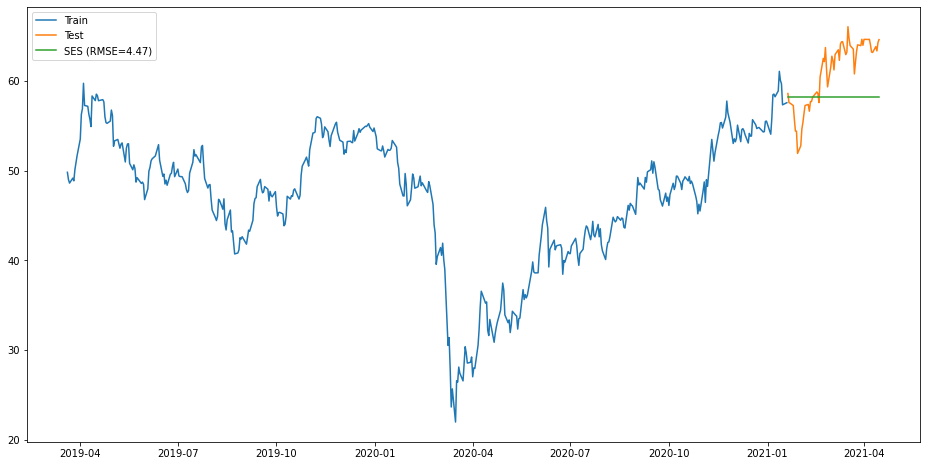

In [36]:
pred = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Close'])).fit(smoothing_level=0.2,optimized=False)# alpha=0.2
pred['SES'] = fit2.forecast(len(test))
# Calculate KPI's
mae = mean_absolute_error(test.Close, pred.SES)
mse=mean_squared_error(test.Close, pred.SES)
rmse = sqrt(mean_squared_error(test.Close, pred.SES))
print("MAE {:,.2f}".format(mae))
print("MSE {:,.2f}".format(mse))
print("RMSE {:,.2f}".format(rmse))

final_result = {'Model': 'SES', 'MAE Train': mae, 'MAE Test':mae}
df_final_result=df_final_result.append(OrderedDict(final_result),ignore_index=True)

# Plot
plt.figure(figsize=(16,8))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(pred['SES'], label='SES (RMSE={:.2f})'.format(rmse)) 
plt.legend()
plt.show()

In [37]:
pred

,Close,SES
Date,,
2021-01-20,58.57,58.16
2021-01-21,57.56,58.16
2021-01-22,57.50,58.16
2021-01-25,57.23,58.16
2021-01-26,55.74,58.16
2021-01-27,54.39,58.16
2021-01-28,54.38,58.16
2021-01-29,51.90,58.16
2021-02-01,52.75,58.16


## Double Exponential Smoothing (Holt)

MAE 9.44
MSE 125.11
RMSE 11.19


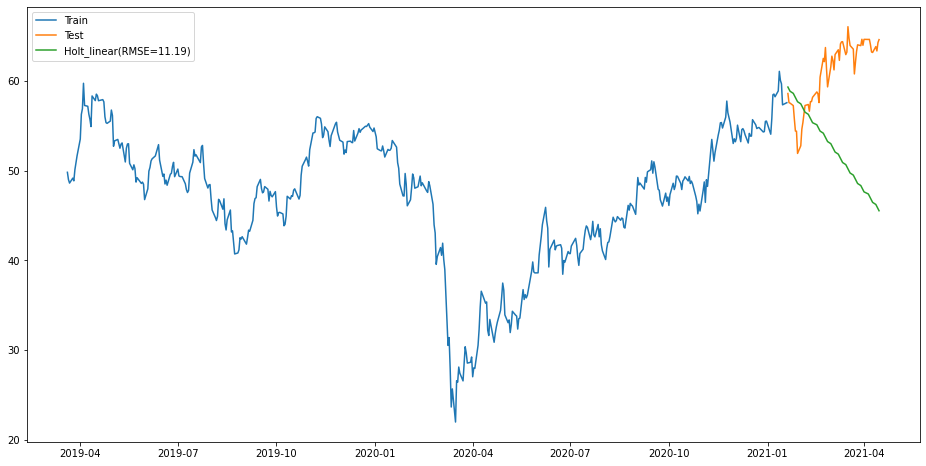

In [38]:
# Fit the model
pred = test.copy()
fit1 = Holt(np.asarray(train['Close'])).fit(smoothing_level = 0.3,smoothing_slope = 0.4)
pred['Holt_linear'] = fit1.forecast(len(test))
# Calculate KPI
mae = mean_absolute_error(test.Close, pred.Holt_linear)
mse=mean_squared_error(test.Close, pred.Holt_linear)
rmse = sqrt(mean_squared_error(test.Close, pred.Holt_linear))
print("MAE {:,.2f}".format(mae))
print("MSE {:,.2f}".format(mse))
print("RMSE {:,.2f}".format(rmse))

final_result = {'Model': 'DES', 'MAE Train': mae, 'MAE Test':mae}
df_final_result=df_final_result.append(OrderedDict(final_result),ignore_index=True)

# Plot
plt.figure(figsize=(16,8))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(pred['Holt_linear'], label='Holt_linear(RMSE={:.2f})'.format(rmse))
plt.legend()
plt.show()

In [39]:
pred

,Close,Holt_linear
Date,,
2021-01-20,58.57,59.29
2021-01-21,57.56,59.06
2021-01-22,57.50,58.82
2021-01-25,57.23,58.59
2021-01-26,55.74,58.36
2021-01-27,54.39,58.12
2021-01-28,54.38,57.89
2021-01-29,51.90,57.66
2021-02-01,52.75,57.42


## Triple Exponential Smoothing

MAE 3.81
MSE 19.29
RMSE 4.39


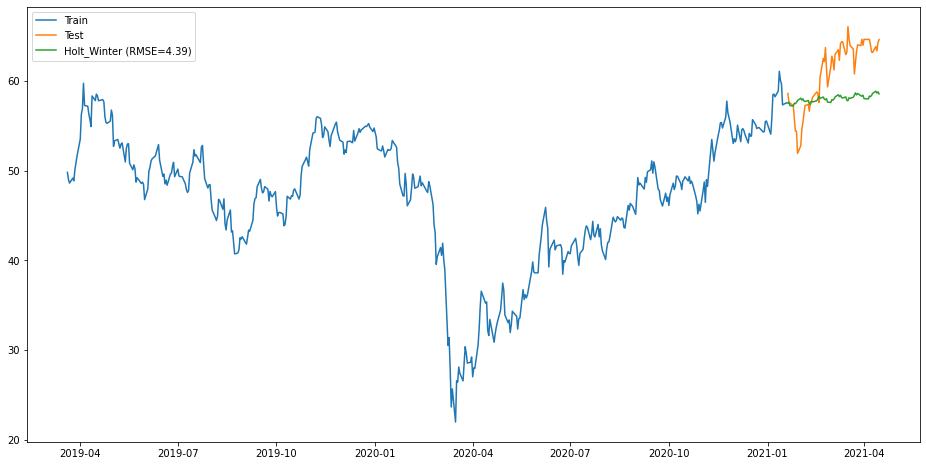

In [40]:
# Fit the model
pred = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Close']) ,seasonal_periods=12 ,trend='add', seasonal='add').fit()

pred['Holt_Winter'] = fit1.forecast(len(test))
# Calculate KPI's
mae = mean_absolute_error(test.Close, pred.Holt_Winter)
mse=mean_squared_error(test.Close, pred.Holt_Winter)
rmse = sqrt(mean_squared_error(test.Close, pred.Holt_Winter))
print("MAE {:,.2f}".format(mae))
print("MSE {:,.2f}".format(mse))
print("RMSE {:,.2f}".format(rmse))

final_result = {'Model': 'TES', 'MAE Train': mae, 'MAE Test':mae}
df_final_result=df_final_result.append(OrderedDict(final_result),ignore_index=True)

# Plot
plt.figure(figsize=(16,8))
plt.plot( train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(pred['Holt_Winter'], label='Holt_Winter (RMSE={:.2f})'.format(rmse))

plt.legend()
plt.show()

In [41]:
pred

,Close,Holt_Winter
Date,,
2021-01-20,58.57,57.48
2021-01-21,57.56,57.60
2021-01-22,57.50,57.22
2021-01-25,57.23,57.18
2021-01-26,55.74,57.50
2021-01-27,54.39,57.44
2021-01-28,54.38,57.57
2021-01-29,51.90,57.80
2021-02-01,52.75,58.05


# <font color='RED'> Final Conclusion </font>

In [42]:
df_final_result=df_final_result.sort_values(by=['MAE Test'], ascending=True)
df_final_result

,MAE Test,MAE Train,Model
0,0.12,0.18,LSTM
1,1.74,1.74,MA
4,3.81,3.81,TES
2,3.92,3.92,SES
3,9.44,9.44,DES


#### MAE of LSTM model is the smallest that are 0.18 for training phase and 0.12 for test phase within sample. The forecast for next 2 weeks (14 days) tends to go up.  
#### MA and Exponential Smoothing Models are not well fit due to larger MAE.  


#### - In this project, we practiced some learnt time-series methods to create stock price prediction model. The best model looks good in train and test phases within sample data. However, we cannot evaluate for out-of-sample data. 

#### - Moreover, we need to investigate to do comprehensive evaluation process to make sure model performance. For example: monitor training and testing phases to evaluate model fitting (over/under or well fit), or training / testing / forecasting duration, ect.)  
